In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/pcs/patrick/Dokumente/Github/colormap/"))
import colormaps as cmaps


In [3]:
import numpy as np
import scipy.constants as cs
import scipy.special as ss
from matplotlib import pyplot as plt
from matplotlib import cm
from qkit.qkit.gui.notebook.Progress_Bar import Progress_Bar as pb
from scipy.integrate import dblquad
from scipy import integrate

%matplotlib inline

In [4]:
#customized plots:
import matplotlib 
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (10.0,5.0)
matplotlib.rcParams['savefig.dpi'] = 100
matplotlib.rcParams['legend.shadow'] = True
matplotlib.rcParams['savefig.bbox'] = 'tight'


cmap_virdis = cmaps.viridis.colors


In [5]:
labelsize = 27

In [6]:
mu_0 = cs.mu_0                                     #vacuum susceptiblity
mu_B = cs.physical_constants['Bohr magneton'][0]   #Bohr magneton in SI units
k_b = cs.k                                         #K boltzmann
e = cs.e                                           #electron charge
hbar = cs.hbar
h = cs.h
phi_0 = cs.physical_constants['mag. flux quantum'][0]

### qubit specification:

In [7]:
tau_p = 1.*10**(-9)   #minimal pulse duration 
print 'minimum pulse duration: tau_p = {} ns'.format(tau_p*10**9)

minimum pulse duration: tau_p = 1.0 ns


In [8]:
Echarge = hbar/tau_p
print Echarge/h*10**-9

0.159154943092


In [9]:
C = tau_p*e**2./(2.*hbar)
print 'qubit capacitance: C = {}'.format(C)

qubit capacitance: C = 1.21706740304e-13


In [10]:
Ec = e**2/(2.*C)
deltafcap = Ec/h
print 'qubit frequency shift due to Ec: deltaf = {} MHz'.format(deltafcap/10**6)

qubit frequency shift due to Ec: deltaf = 159.154943092 MHz


In [11]:
EJ = 200*Ec

In [12]:
'''EJ = 200*Ec
LJ = phi_0**2./(4.*np.pi*EJ)
Ic = 2.*np.pi*EJ/phi_0
print 'qubit (kinetic) inductance: L = {}'.format(LJ)
print 'Junction critical current: Ic = {} nA'.format(Ic*10**9)'''

"EJ = 200*Ec\nLJ = phi_0**2./(4.*np.pi*EJ)\nIc = 2.*np.pi*EJ/phi_0\nprint 'qubit (kinetic) inductance: L = {}'.format(LJ)\nprint 'Junction critical current: Ic = {} nA'.format(Ic*10**9)"

### readout resonator:

In [13]:
Tp = 10*10.**(-6)      #relaxation time due to purcell effect

In [14]:
fc = 6.*10**9                 #resonator frequency
kappa = 10*10**6              #resonator decay rate/linewidth
QL = (2.*np.pi*fc)/kappa      #resonator quality factor
print 'resonator decay rate: kappa = {} MHz'.format(kappa*10**-6)
print 'resonator quality factor: QL = {}'.format(QL)

resonator decay rate: kappa = 10.0 MHz
resonator quality factor: QL = 3769.91118431


In [15]:
goD = np.sqrt(1./(Tp*kappa))   #ratio between coupling strength and detuning for a Purcell limited T1
print 'ratio between coupling strength and detuning: g/D = {}'.format(goD)

ratio between coupling strength and detuning: g/D = 0.1


In [16]:
chi = kappa
print 'dispersive shift: chi = {} MHz'.format(chi*10**-6)

dispersive shift: chi = 10.0 MHz


In [17]:
g = kappa/goD  #coupling strength
print 'qubit-resonator coupling strength: g = {} MHz'.format(g*10**-6)

qubit-resonator coupling strength: g = 100.0 MHz


In [18]:
DELTA = g/goD
print 'qubit-resonator detuning: DELTA = {} GHz'.format(DELTA*10**-9)

qubit-resonator detuning: DELTA = 1.0 GHz


In [19]:
fq = fc - DELTA
print 'qubit frequency: fq = {} GHz'.format(fq*10**-9) 

qubit frequency: fq = 5.0 GHz


In [20]:
LJ2 = 1./((2.*np.pi*fq)**2.*C) 
print 'qubit inductance: LJ = {} nH'.format(LJ2*10**9)
Ic2 = phi_0/(2.*np.pi*LJ2)
print 'qubit crit. current: Ic = {} nA'.format(Ic2*10**9)

qubit inductance: LJ = 8.32502648488 nH
qubit crit. current: Ic = 39.5321235667 nA


In [21]:
EJ2 = phi_0*Ic2/(2.*np.pi)
print 'EJ/hbar = {} GHz'.format(EJ2/hbar*10**-9)
print 'Ec/hbar = {} GHz'.format(Ec/hbar*10**-9)

EJ/hbar = 123.370054993 GHz
Ec/hbar = 1.0 GHz


In [22]:
print 'EJ/h = {} GHz'.format(EJ2/h*10**-9)
print 'Ec/h = {} GHz'.format(Ec/h*10**-9)

EJ/h = 19.6349540817 GHz
Ec/h = 0.159154943092 GHz


In [23]:
print 'EJ/Ec = {}'.format(EJ2/Ec)

EJ/Ec = 123.370054993


### Concentric Transmon:

In [24]:
EJcT = 45*10**9.   #divided by h
ELcT = 128*10**9.  #divided by h
ELtot = (1/EJcT + 1/ELcT)**-1               #total inductive energy
ECcT = 0.24*10**9. #divided by h
fcT01 = (np.sqrt(8.*(ELtot)*ECcT)-ECcT)
print 'qubit res. freq.: f01 = {}'.format(fcT01*10**-9)

qubit res. freq.: f01 = 7.75537438527


In [25]:
EJcT/ECcT

187.5

In [26]:
IccT = 90.*10**-9

In [27]:
CcT = 81*10**-15

### Eigenenergies:

In [28]:
def k(m,ng):
    k = 0.
    k_array = []
    l = [+1,-1]
    try:
        for j in ng:
            k = 0
            for i in l:
                k += (np.mod(int(2.*j+i/2.),2))*(int(j)+i*(-1)**m*(int((m+1.)/2.)))
            k_array.append(k)
        return k_array
    except:
        for i in l:
            k += (np.mod(int(2.*ng+i/2.),2))*(int(ng)+i*(-1)**m*(int((m+1.)/2.)))
        return k

In [29]:
def Em(m,ng, Ec, EJ):
    '''Transmon eigenenergies in the phase basis;
    Mathieu function returns nan for negative index v (-> absolute value)'''
    E_array = []
    try:
        for i in ng:
            v = 2.*(i+k(m,i))
            E_array.append(Ec*ss.mathieu_a(v,-2.*EJ/(Ec)))
        return np.array(E_array)
    except:
        v = 2.*(ng+k(m,ng))
        return Ec*ss.mathieu_a(v,-EJ/(2.*Ec))

In [30]:
Em(1,5.1,Ec,EJ)

nan

In [31]:
ng = np.linspace(-2.,2.,100)

In [34]:
#Em(1,ng, Ec, EJ)

In [35]:
def EmTM(m, Ec,EJ):
    return -EJ+np.sqrt(8.*EJ*Ec)*(m+0.5)-Ec*(6.*m**2.+6*m+3.)/12

In [36]:
def DeltaEm(m, EJEC, Ec):
    return (np.sqrt(8.*EJEC)*m-(6.*m**2.+6.*m)/12.)

In [37]:
EmTM(1,Ec,EJ)

-1.4895826676964966e-23

In [38]:
EmTM(3,Ec,EJ)/EmTM(1,Ec,EJ)

0.46902654867256621

In [39]:
EJEC = np.linspace(0,140,1000)

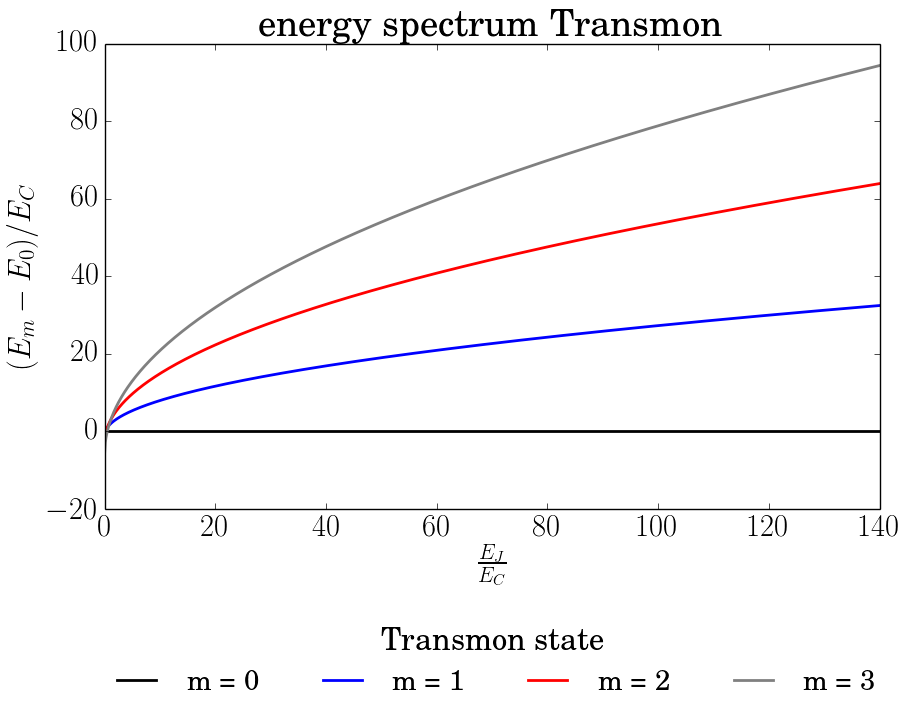

In [40]:
fig_Em, ax = plt.subplots(figsize =(10,6))
ax.set_xlabel(r'$\frac{E_J}{E_C}$')
ax.set_ylabel(r'$(E_m - E_0)/E_C$')
ax.set_title(r'energy spectrum Transmon')
ax.plot(EJEC, DeltaEm(0,EJEC,Ec), label = 'm = 0', color = 'black', lw = 2)
ax.plot(EJEC, DeltaEm(1,EJEC,Ec), label = 'm = 1', color = 'blue', lw = 2)
ax.plot(EJEC, DeltaEm(2,EJEC,Ec), label = 'm = 2', color = 'red', lw = 2)
ax.plot(EJEC, DeltaEm(3,EJEC,Ec), label = 'm = 3', color = 'grey', lw = 2)
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5,-0.2), ncol = 4, fontsize =20, frameon = False, title = 'Transmon state')


In [41]:
def K11(a,l,Ec):
    '''self-Kerr for the fundamental mode of a granular aluminum resonator
    omega: resonance frequency
    a: approximately grain size
    l: length
    Ic: critical current of a single junction'''
    return -3.*np.pi*a**2.*Ec/(4.*l**2.*hbar)

In [42]:
def selfK(a,l,Ec):
    '''Self Kerr calculated with an Junction array shunted by 
    a large capacitance'''
    return -2*a**2.*Ec/(3.*l**2.*hbar)

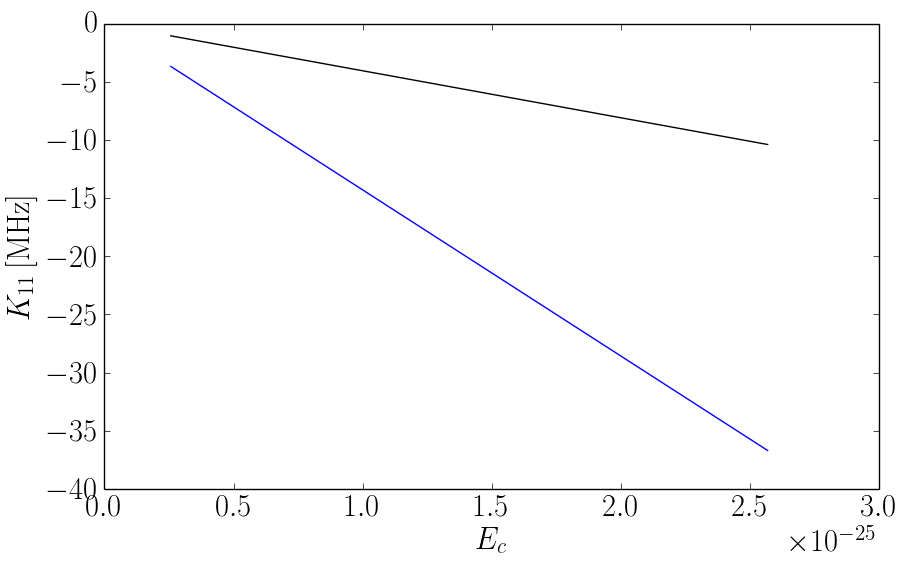

In [43]:
a = 4.*10**-9 #grainsize
l = 50.*10**-9 #GraAl length
C1 = 500*10**-15.
C2 = 50*10**-15.
Ec1 = e**2/(2.*C1)
Ec2 = e**2./(2.*C2)
Ecc = np.linspace(Ec1,Ec2, 100)
figKerr, ax = plt.subplots(figsize = (10,6))
ax.set_ylabel(r'$K_{11}\,\mathrm{[MHz]}$')
ax.set_xlabel(r'$E_c$')
ax.plot(Ecc, selfK(a,l,Ecc)/10**6, color = 'black')
ax.plot(Ecc, K11(a,l,Ecc)/10**6, color = 'blue')

In [46]:
import qutip.testing as qt

In [47]:
qt.run()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
Alexander Pitchford, Chris Granade, Paul D. Nation & Robert J. Johansson

QuTiP Version:      4.0.2
Numpy Version:      1.8.2
Scipy Version:      0.19.0
Cython Version:     0.25.2
Matplotlib Version: 1.3.1
Python Version:     2.7.6
Number of CPUs:     4
BLAS Info:          INTEL MKL
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /usr/local/lib/python2.7/dist-packages/qutip



ImportError: No module named nose